# ***Muziek classificeren***

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Declan van den Hoek|declanvdh|DeclanvandenHoek|
|Isa Dijkstra|isadijkstra|IsaD01|

In dit notebook gaan we kleine muziek samples classificeren met behulp van unsupervised learning. Een deel van deze bestand heeft een genre label, terwijl de meeste dit niet zullen hebben. Aan ons is de taak om zo accuraat mogelijk te bepalen welke genres de unlabeled samples hebben, door middel van Unsupervised Learning.

Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning/tree/main/Muziek), om makkelijk de bestanden te delen. Van elk model zijn de voorspellingen ook geupload naar [Kaggle](https://www.kaggle.com/competitions/muziek-genre-clustering/overview).

## **Libaries en data inladen** <a name='h1'></a>

In [1]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from librosa.core import stft
from librosa.core import amplitude_to_db
import librosa.feature as lf
from librosa.feature import spectral_bandwidth, spectral_centroid
import librosa
import librosa.display
import IPython.display as ipd

# Om audio af te kunnen spelen
from IPython.display import Audio

In de onderstaande cel, die gebaseerd is op de code van het Machine Learning notebook uit week 11, wordt de data ingelezen en in een dataframe gezet.

In [2]:
def mfccs(data, sfreq):
    """
    Bereken Mel Frequency Cepstral Coefficients
    (MFCCs) voor het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Toepassen van mfcc via librosa
    mfcc = lr.feature.mfcc(y=data, sr=sfreq)
    datadict = {}

    # Vullen van datadict
    for var in range(len(mfcc)):
        datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc[var, :])

    return datadict

def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Bereken het spectrogram voor elk audiofragment in de audio_clips-reeks.

    Parameters:
    ----------
    audio_clips : lijst
        Een lijst met audioclips (numpy-arrays).
    n_fft : int, optioneel
        Het aantal datapunten dat wordt gebruikt in elk blok voor de FFT (standaard 2048).
    hop_length : int, optioneel
        Het aantal samples tussen opeenvolgende frames (standaard 512).
    win_length : int, optioneel
        De venstergrootte (standaard is `n_fft`).

    Returns:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen die overeenkomen met elk audioclip.
    spec_db : array
        De spectrogrammen in decibels, voor het plotten.
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(y=clip,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)

        # Convert to decibels. Use amplitude_to_db() here.
        spec_db = amplitude_to_db(S=spectrogram,
                                  ref=np.max)

        # Append the spectrogram to the list
        spectrograms.append(spectrogram)

        # Append spectrogram in decibels to the list
        spectrograms_db.append(spec_db)

    return spectrograms, spectrograms_db


def calculate_spectral_features(spectrograms):
    """
    Bereken de centroid en bandbreedte voor elk spectrogram in een lijst.

    Parameters:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen.

    Returns:
    ----------
    bandwidths : lijst
        Een lijst met bandbreedtes die overeenkomen met elk spectrogram.
    centroids : lijst
        Een lijst met centroids die overeenkomen met elk spectrogram.
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        spec_bw = spectral_bandwidth(S=spectrogram)

        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        spec_cn = spectral_centroid(S=spectrogram)

        # Append the spectral bandwidth to the list
        bandwidths.append(spec_bw)

        # Append the spectral centroid to the list
        centroids.append(spec_cn)

    return bandwidths, centroids

def calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
    """
    Bereken spectrale contrasten van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_contrast : array
        Spectrale contrasten.
    """
    spectral_contrast = lf.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)

    return spectral_contrast

def calculate_tonnetz(data, sr):
    """
    Bereken de tonnetz-functies van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    tonnetz : array
        Tonnetz-functies.
    """
    tonnetz = lf.tonnetz(y=data, sr=sr)

    return tonnetz

def calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
    """
    Bereken de spectrale rolloff van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    roll_percent : float, optioneel
        Percentage van de spectrale energie waar de rolloff wordt berekend (standaard 0.85).
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_rolloff : array
        Spectrale rolloff.
    """
    spectral_rolloff = lf.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)

    return spectral_rolloff

Nu de functies en features zijn uitgelegd en opgezet, kan de data ingeladen worden samen met de features.

In [3]:
# Load labeled data from CSV
labeled_data = pd.read_csv("labels_new.csv", sep=',')
labeled_data = labeled_data.sort_values('filename')

def load_music(directory):
    # Aanmaken lists voor data
    audio_data = []
    sample_freqs = []
    mfcc_data = {}

    # Lengte is 30 sec op 22050Hz
    lengte = 30 * 22050

    # Process each audio file
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            data, sfreq = lr.load(file_path, sr=None)

            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)

            # Make the mfcc data using your custom function
            mfcc_dict = mfccs(data, sfreq)

            # Update the dictionary with individual MFCC coefficients
            for key, value in mfcc_dict.items():
                if key not in mfcc_data:
                    mfcc_data[key] = []
                mfcc_data[key].append(value)

    # Convert to numpy array
    audio_data = np.stack(audio_data, axis=0)
    sample_freqs = np.array(sample_freqs)

    # Create a DataFrame from the processed audio data
    df = pd.DataFrame({
        'filename': os.listdir(directory),
        'data': audio_data.tolist(),
        'Hz': sample_freqs.tolist(),
    })

    # Add columns for each MFCC coefficient
    for key, values in mfcc_data.items():
        df[key] = values

    # Merge the labeled_data DataFrame with the audio_df DataFrame based on the 'filename' column
    if directory == "labeled":
        df = labeled_data.merge(df, how='left', on='filename')

    # Calculate spectrograms
    spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)
    bandwidths, centroids = calculate_spectral_features(spectrograms)
    spectral_contrast = calculate_spectral_contrast(audio_data, sfreq, n_fft=2048, hop_length=512)
    tonnetz = calculate_tonnetz(audio_data, sfreq)
    spectral_rolloff = calculate_spectral_rolloff(audio_data, sfreq, roll_percent=0.85, n_fft=2048, hop_length=512)

    # Adding these columns to the dataframe
    df['mean_bandwidth'] = [np.mean(arr) for arr in bandwidths]
    df['mean_centroids'] = [np.mean(arr) for arr in centroids]
    df['mean_spectral_contrast'] = [np.mean(arr) for arr in spectral_contrast]
    df['mean_tonnetz'] = [np.mean(arr) for arr in tonnetz]
    df['mean_spectral_rolloff'] = [np.mean(arr) for arr in spectral_rolloff]

    # Display the merged DataFrame
    df = df.set_index('filename')
    display(df.head())

    return df

In [70]:
labeled = load_music("labeled")

,genre,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,...,13.479482,9.419415,6.914652,7.877784,-1.782740,1919.917650,1451.498371,24.225544,0.000351,3046.089914
m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,...,1.102363,-4.261436,4.327076,-3.458247,1.208493,2019.252686,1811.358216,22.132186,0.016613,3854.901690
m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,...,-3.588230,0.891752,-0.496282,0.708363,1.672521,2992.192112,3111.061099,17.239507,-0.035761,6745.275879
m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,-69.599335,83.059570,-16.599525,0.119469,7.415704,0.769619,1.337008,...,-1.885092,4.043784,3.654379,1.913874,3.608692,2709.990169,2625.095044,19.452643,-0.018575,5606.407765
m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,-91.886307,87.604057,-2.058175,34.285538,-18.153368,19.344702,-14.697328,...,-1.051909,-11.649620,0.293441,-1.279737,0.098982,2486.020650,2550.135384,21.882917,0.009210,5585.291227


Nu de data is ingeladen kunnen we met behulp van de Audio functie een bestand afspelen in het notebook.

In [5]:
# Pick a random audio clip
random_filename = np.random.choice(labeled.index, size=1, replace=False).item()

# Access the data, Hz and genre
clip = np.array(labeled.at[random_filename, 'data'])
sfreq = labeled.at[random_filename, 'Hz']
genre = labeled.at[random_filename, 'genre']

# Tonen van bestandsnaam en het genre
print(f"Bestand en genre: {random_filename}, {genre}")

# Play the clip
Audio(data=clip, rate=sfreq)

Bestand en genre: m00821.wav, metal


## **Feature Engineering** <a name='h2'></a>

### Spectrale Bandbreedte voor Geluid
**Uitleg:**<br>
*Spectrale bandbreedte* voor geluid verwijst naar het bereik van frequenties in het geluidsspectrum. Het geeft aan hoe breed het frequentiebereik van een geluidssignaal is. Een bredere spectrale bandbreedte duidt op een geluid met diverse frequentiecomponenten, terwijl een smallere bandbreedte kan wijzen op een meer gefocust geluid.

**Formule:**<br>
De spectrale bandbreedte ($ \Delta f $) voor geluid kan worden berekend met de formule:<br>
$ \Delta f = f_{\text{hoge}} - f_{\text{lage}} $<br>
waarbij:
- $ f_{\text{hoge}} $ de frequentie van de hoogste aanwezige frequentie in het geluid is,
- $ f_{\text{lage}} $ de frequentie van de laagste aanwezige frequentie in het geluid is.

### Spectrale Centroiden voor Geluid
**Uitleg:**<br>
*Spectrale centroiden* voor geluid geven het gemiddelde aan van de frequenties in het geluidsspectrum. Het wordt gebruikt om het "zwaartepunt" van de spectrale inhoud van een geluidssignaal te bepalen.

**Formule:**<br>
De spectrale centroidfrequentie ($ f_c $) voor geluid kan worden berekend met de formule (Nam, 2001):<br>
$ f_c = \frac{\sum_{i=1}^{N} f_i \cdot A_i}{\sum_{i=1}^{N} A_i} $<br>
waarbij:
- $ N $ het aantal frequentiebanden is,
- $ f_i $ de frequentie is van het i-de frequentieband,
- $ A_i $ de amplitude is van het i-de frequentieband.

### Tonnetz
**Uitleg:**<br>
De *Tonnetz* is een representatie van muzikale tonen in een driedimensionale ruimte. Het wordt vaak gebruikt voor de analyse van muzikale harmonie en modulatie. In het geval van een spectrogram wordt de Tonnetz meestal berekend op basis van een chromagram, afgeleid van het spectrogram.

**Formule:**<br>
Voor de tonnetz kon geen exacte formule worden gevonden. Het wordt in librosa berekent door chroma features te projecteren op een 6-dimensionale basis die de perfecte kwint, kleine terts en grote terts elk als tweedimensionale coördinaten voorstelt. (Librosa.Feature.Tonnetz — Librosa 0.10.1 Documentation, n.d.)

### Spectrale Rolloff
**Uitleg:**<br>
De *Spectrale Rolloff* is een maat voor de steilheid van het spectrum van een geluidssignaal. Het geeft aan welk percentage van de totale spectrale energie zich onder een bepaalde frequentie bevindt.

**Formule:**<br>
Voor spectrale rolloff was ook geen formule te vinden. Volgens de documentatie van Librosa vertegenwoordigt de spectrale rolloff specifiek de frequentie waarbij een bepaald percentage (aangegeven door 'roll_percent', default = 0.85) van de totale spectrale energie is geconcentreerd.

### Spectrale Contrast
**Uitleg:**<br>
*Spectrale Contrast* is een maatstaf voor het verschil in amplitude tussen pieken en dalen in het geluidsspectrum. Het geeft informatie over de variabiliteit van de spectrale energie.

**Formule:**<br>
Spectrale Contrast ($ SC $) wordt berekend met de formule:<br>
$ SC = \frac{\text{Gemiddelde van de hoogste amplitudes}}{\text{Gemiddelde van de laagste amplitudes}} $<br>
waarbij de hoogste en laagste amplitudes worden genomen over specifieke frequentiebanden.


In [6]:
def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Bereken het spectrogram voor elk audiofragment in de audio_clips-reeks.

    Parameters:
    ----------
    audio_clips : lijst
        Een lijst met audioclips (numpy-arrays).
    n_fft : int, optioneel
        Het aantal datapunten dat wordt gebruikt in elk blok voor de FFT (standaard 2048).
    hop_length : int, optioneel
        Het aantal samples tussen opeenvolgende frames (standaard 512).
    win_length : int, optioneel
        De venstergrootte (standaard is `n_fft`).

    Returns:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen die overeenkomen met elk audioclip.
    spec_db : array
        De spectrogrammen in decibels, voor het plotten.
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(y=clip,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)

        # Convert to decibels. Use amplitude_to_db() here.
        spec_db = amplitude_to_db(S=spectrogram,
                                  ref=np.max)

        # Append the spectrogram to the list
        spectrograms.append(spectrogram)

        # Append spectrogram in decibels to the list
        spectrograms_db.append(spec_db)

    return spectrograms, spectrograms_db


def calculate_spectral_features(spectrograms):
    """
    Bereken de centroid en bandbreedte voor elk spectrogram in een lijst.

    Parameters:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen.

    Returns:
    ----------
    bandwidths : lijst
        Een lijst met bandbreedtes die overeenkomen met elk spectrogram.
    centroids : lijst
        Een lijst met centroids die overeenkomen met elk spectrogram.
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        spec_bw = spectral_bandwidth(S=spectrogram)

        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        spec_cn = spectral_centroid(S=spectrogram)

        # Append the spectral bandwidth to the list
        bandwidths.append(spec_bw)

        # Append the spectral centroid to the list
        centroids.append(spec_cn)

    return bandwidths, centroids

def calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
    """
    Bereken spectrale contrasten van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_contrast : array
        Spectrale contrasten.
    """
    spectral_contrast = lf.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)

    return spectral_contrast

def calculate_tonnetz(data, sr):
    """
    Bereken de tonnetz-functies van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    tonnetz : array
        Tonnetz-functies.
    """
    tonnetz = lf.tonnetz(y=data, sr=sr)

    return tonnetz

def calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
    """
    Bereken de spectrale rolloff van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    roll_percent : float, optioneel
        Percentage van de spectrale energie waar de rolloff wordt berekend (standaard 0.85).
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_rolloff : array
        Spectrale rolloff.
    """
    spectral_rolloff = lf.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)

    return spectral_rolloff

## **MFCC functie**

Volgens Singh (2021) dienen Mel Frequency Cepstral Coefficients (MFCC's) als een representatie van het spectrum in een audio-signaal. Dit wordt bereikt door het signaal uit te drukken als een som van verschillende sinusgolven. In de onderstaande tekst wordt het process voor de MFCC uitgelegd, de wiskundige informatie is verkregen door gebruik van verschillende bronnen.

Het proces begint met het opdelen van het signaal in korte tijdsframes om veranderingen in frequentie vast te leggen. Dit wordt gedaan om ervoor te zorgen dat de eigenschappen van het geluid in de tijd goed worden weergegeven. Dit staat ook wel bekend als windowing.

   Wiskundige representatie windowing (Wikipedia, 2023):
   $ x(n) = x[n] \cdot w(n) $<br>
   Hierbij is:
   - $x(n)$ het oorspronkelijke signaal
   - $x[n]$ is het gevensterde signaal
   - $w(n)$ is de vensterfunctie.

Vervolgens wordt de Discrete Fourier Transformatie (DFT) toegepast. Dit houdt in dat op elk tijdsframe een FFT wordt uitgevoerd, wat resulteert in een frequentiespectrum. Hiermee krijgt men inzicht in de frequentiecomponenten van het geluid gedurende elk kort tijdsinterval.

   Wiskundige representatie van DFT (Discrete Fourier Transform | Brilliant Math & Science Wiki, n.d.): $ X_k = \sum_{n=0}^{N-1} x_n e^{-\frac{N}{2}\pi i k n} $<br>
   Hierbij is:
   - $X_k$ de DFT coëfficiënt
   - $k$ de frequentie-index
   - $N$ het aantal elementen van de reeks $x_n$
   - $x_n$ vertegenwoordigt de waarden van de reeks op discrete tijdsindices $n$
   - $e$ het natuurlijk logaritme
   - $i$ de imaginaire eenheid

Een volgende stap omvat het gebruik van Mel-gespreide Filterbanken. Deze filterbanken bestaan uit 20-40 driehoekige filters die op een specifieke manier over het frequentiespectrum zijn verdeeld. De filterbanken uiten zich wiskundig als een matrix. Vervolgens wordt elk tijdsframe vermenigvuldigd met de verkregen matrices, en de resulterende coëfficiënten worden opgeteld. Dit geeft een indicatie van de energie in verschillende frequentiebanden.

   Wiskundige representatie:
   $ C_m = \sum_{k=0}^{N-1} \log(|X(k)|) \cdot Filterbank $

Om de gegevens verder te verfijnen, worden logaritmes toegepast op de spectrogramwaarden. Dit resulteert in log-filterbankenergieën, waardoor de representatie van de audio-spectra meer overeenkomt met de menselijke perceptie van geluid.

   Wiskundige representatie:
   $ C_m' = \log(C_m) $

Dit proces resulteert in wat we Mel Frequency Cepstral Coefficients noemen. Deze coëfficiënten vormen een gestructureerde set getallen die een compacte representatie bieden van de spectrale kenmerken van het oorspronkelijke geluidssignaal. In python is het gelukkig mogelijk om deze stappen uit te laten voeren door middel van de librosa library.


In [8]:
def mfccs(data, sfreq):
    """
    Bereken Mel Frequency Cepstral Coefficients
    (MFCCs) voor het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Toepassen van mfcc via librosa
    mfcc = lr.feature.mfcc(y=data, sr=sfreq)
    datadict = {}

    # Vullen van datadict
    for var in range(len(mfcc)):
        datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc[var, :])

    return datadict

## Unsupervised learning


In [9]:
unlabeled = load_music("unlabeled")

,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,"[-0.129364013671875, -0.1422119140625, -0.1157...",22050,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,...,5.177265,-7.204545,0.667606,-4.838900,-2.107008,2070.908729,2254.451748,20.382411,0.005218,4381.173508
m00012.wav,"[-0.003814697265625, 0.089080810546875, 0.1600...",22050,-1.925411,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,...,5.310404,-9.025781,4.315321,-5.643383,8.725261,2286.246872,2908.260266,20.043229,0.001804,5405.642313
m00013.wav,"[0.004791259765625, 0.0048828125, 0.0045166015...",22050,-287.520996,101.737930,-35.368999,41.282764,-12.745123,17.284992,-13.978298,16.311884,...,6.985262,7.031875,8.390631,-5.610771,1.377122,1865.851544,1953.012399,23.257077,0.012233,3780.543806
m00043.wav,"[-0.11505126953125, -0.12127685546875, -0.1372...",22050,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123723,23.654572,...,1.024725,-10.713960,-3.241502,-3.466504,-4.576841,2073.302486,2384.812610,19.721734,0.014826,4585.038942
m00044.wav,"[-0.017822265625, -0.016693115234375, -0.01486...",22050,-437.525208,170.971405,7.386171,-3.108705,0.777302,-11.135056,-12.523807,-6.900928,...,-7.060068,-6.652506,-4.291024,-4.399244,-4.915998,899.979779,790.478225,20.256635,-0.024661,1159.401323


In [10]:
# Scalen van de data
def scaler(dataframe):
    """
    Scale a DataFrame based on the Z-score.

    Parameters:
    - dataframe: The input DataFrame.

    Returns:
    - scaled_dataframe: The scaled DataFrame.
    """
    
    mean_data = dataframe.mean(numeric_only=True)
    std_dev_data = dataframe.std(ddof=0, numeric_only=True)
    
    scaled_dataframe = (dataframe - mean_data) / std_dev_data
    return scaled_dataframe

scdf = scaler(unlabeled)
scdf = scdf.drop(['data', 'Hz'], axis=1)
display(scdf)

,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-0.282118,-0.118884,0.078336,-0.205532,-0.332126,0.799924,-0.702495,1.488357,-1.685314,1.456281,...,0.484487,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265
m00012.wav,0.019216,0.616770,-0.083214,0.293430,-0.452162,1.774594,-1.563891,2.138239,-1.147957,1.455962,...,1.074915,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620
m00013.wav,-0.569065,-0.458058,1.447517,-0.498065,-0.085519,1.003829,-0.550030,-0.412775,-1.571745,1.161850,...,-1.017818,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202
m00043.wav,-0.278768,0.027796,-0.236340,-0.106240,0.005644,0.965347,-0.670623,1.455360,-0.839766,0.583486,...,0.208774,-1.208862,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518
m00044.wav,-1.920661,-1.766122,0.018429,-1.774679,-1.382611,-1.840896,-0.487663,-1.535571,-0.520888,-1.476432,...,-2.116991,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570093,-0.993139,-1.095278,-0.188952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.957653,-0.938974,-0.551006,-1.008327,0.725921,-1.676399,0.555313,-1.169117,0.266517,-1.033799,...,-0.715169,0.042968,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994
m00973.wav,1.431593,1.475285,-1.196850,1.498087,-1.137006,-0.110127,0.497143,-0.286592,0.372095,-0.688076,...,1.026509,0.745321,-1.137606,1.381635,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714
m00988.wav,1.523881,1.778059,-1.318630,1.683362,-0.606247,0.000735,1.486701,0.254812,0.771619,0.368334,...,0.678009,-1.140236,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906



### Bepalen van clusters

C:\Users\Gebruiker\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


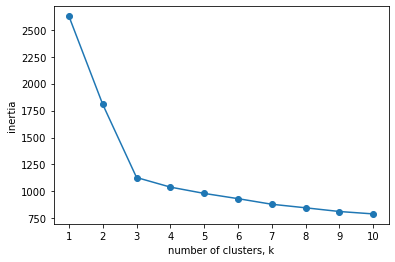

In [11]:
from sklearn.cluster import KMeans

# Ignore the warning about KMeans memory leak
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


inertia = []
k = range(1, 11)

for i in k:
    model = KMeans(n_clusters=i, n_init=10)
    model.fit(scdf)
    inertia.append(model.inertia_)

plt.plot(k, inertia, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

In [12]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
scdf['cluster'] = kmeans.fit_predict(scdf)

print(scdf['cluster'].value_counts())

1    40
0    39
2    26
Name: cluster, dtype: int64


## **Bronnen**
<a href='https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040'>Singh, T. (2021, December 10). MFCC’s Made Easy - Tanveer Singh - medium. Medium.</a><br>
<a href='https://en.wikipedia.org/wiki/Mel-frequency_cepstrum'>Wikipedia contributors. (2023, November 13). Mel-frequency cepstrum. Wikipedia.</a><br>
<a href='https://brilliant.org/wiki/discrete-fourier-transform/'>Discrete Fourier Transform | Brilliant Math & Science Wiki. (n.d.).</a><br>
<a href='https://musicinformationretrieval.com/spectral_features.html'>spectral_features. (n.d.).</a><br>
<a href='https://ccrma.stanford.edu/~unjung/AIR/areaExam.pdf'>Nam, U. (2001, April 28). Special Area Exam Part II.</a><br>
<a href='https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html'>librosa.feature.tonnetz — librosa 0.10.1 documentation. (n.d.).</a><br>
<a href='https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html'>librosa.feature.spectral_rolloff — librosa 0.10.1 documentation. (n.d.).</a><br>


### Root Mean Square energy

De energie van muziek kan ook wel gedefinieerd worden als de intensiteit van de muziek. In praktische termen is dit de amplitude van de golf (?)(Ik breidt het wel uit en zoek er een bron bij)

Dit geeft ons een idee van de algemene intensiteit van een nummer. Theoretisch zou dit kunnen helpen met het onderscheiden tussen genres, een metal nummer zou over het algemeen intenser zijn dan een klassiek stuk. 

In [12]:
def rms_energy_features(data, sfreq):
    """
    Berekent de RMS Energy voor het ingegeven audiobestand.
    
    Parameters:
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Compute RMS Energy
    rms_energy = lf.rms(y=data)[0]

    datadict = {}

    # Fill datadict
    datadict['rms_energy_mean'] = np.mean(rms_energy)

    return datadict

### Chroma Feature

In muziektermen is de chroma feature gerelateerd aan de 12 toon klassen. Hiermee kunnen we een indicatie geven van de toonhoogtes van een muziekfragment. Dit hebben we gekozen omdate verschillende genres muziek over het algemeen ook verschillende tonen gebruiken.

In [13]:
def chroma_features(data, sfreq):
    # Compute Chroma feature
    chroma = lf.chroma_stft(y=data, sr=sfreq)

    datadict = {}

    # Fill datadict
    for var in range(len(chroma)):
        datadict[f'chroma{var + 1}_mean'] = np.mean(chroma[var, :])

    return datadict

### Zero Crossing Rate

De zero crossing rate houd in hoe vaak het (audio)signaal verandert van positief naar negatief of andersom. Hiermee is grofweg te zien hoeveel ruis er in een fragment zit. 

In [14]:
def zero_crossing_rate_features(data, sfreq):
    # Compute Zero Crossing Rate (ZCR)
    zcr = lf.zero_crossing_rate(y=data)

    datadict = {}

    # Fill datadict
    datadict['zcr_mean'] = np.mean(zcr)

    return datadict

# Tempo

Tempo in de muziek verwijst naar de snelheid waarmee een muziekstuk wordt gespeeld. Het tempo wordt vaak afgedrukt in beats per minute (BPM). Hoe hoger het getal, hoe sneller de muziek is. 
- https://tweedehands-gitaar.nl/muziektheorie/begrippen/tempo
- https://librosa.org/doc/main/generated/librosa.beat.beat_track.html

In [15]:
# Analyzing tempo
#Using librosa's beat tracking functionality to estimate tempo
tempo, _ = librosa.beat.beat_track(y=labeled, sr=sfreq)

# Modifying tempo
#Time-stretching to change the tempo
y_stretched = librosa.effects.time_stretch(y=labeled, rate=1.5)

# Displaying the stretched waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y_stretched, sr=sfreq)
plt.title('Time-stretched Waveform')
plt.show()

# Play the time-stretched audio
ipd.Audio(y_stretched, rate=sfreq)


ParameterError: Audio data must be of type numpy.ndarray

In [ ]:
#is een self defined functie nodig want he gebruikt hem eigenlijk maar 1x?


def calculate_tempo(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    tempo1 = []

    for clip in audio_clips:
        
        tempo, _ = librosa.beat.beat_track(y=clip, sr=sfreq)
        
        tempo1.append(tempo)

    return tempo1


In [ ]:
df['tempo'] = calculate_tempo(labeled['data'])
df

In [ ]:
labeled

# Beat

In [ ]:
def calculate_beat(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    beat = []

    for clip in audio_data:

        tempo, beats = librosa.beat.beat_track(y=clip, sr=sfreq)

        beat.append(beats)
    
    return beat

In [ ]:
beats = calculate_beat(audio_data)
df['beat'] = [np.mean(arr) for arr in beats]
df

# Harmonie

Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Uit de functie krijg je een audio tijdserie die de harmonische elementen laat zien.


Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Met behulp van de librosa.effects.hpss(y) functie kun je de harmonische elementen van een audiogolfvorm verkrijgen door de resulterende harmonische component (H) te analyseren.

- https://librosa.org/doc/main/generated/librosa.effects.hpss.html
- http://www.hoorn.be/muziektermen.htm


In [ ]:
def calculate_harmonie(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """


    harmonie = []

    for clip in audio_data:

        harmonic, _ = librosa.effects.hpss(y=clip)

        harmonie.append(harmonic)
        
    return harmonie


In [ ]:
harmonie = calculate_harmonie(audio_data)
df['harmonie'] = [np.mean(arr) for arr in harmonie]
df


# Principal Component Analysis

Principal Component Analysis (PCA) is een methode waarmee je de complexiteit van grote datasets kunt verminderen door ze om te zetten naar een kleiner aantal variabelen, terwijl je toch de belangrijkste informatie uit de oorspronkelijke dataset behoudt.
https://builtin.com/data-science/step-step-explanation-principal-component-analysis

https://www.youtube.com/watch?v=Lsue2gEM9D0

https://www.youtube.com/watch?v=QdBy02ExhGI
    
    

In [13]:
scdf = scaler(unlabeled)
scdf = scdf.drop(['data', 'Hz'], axis=1)
display(scdf)

,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-0.282118,-0.118884,0.078336,-0.205532,-0.332126,0.799924,-0.702495,1.488357,-1.685314,1.456281,...,0.484487,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265
m00012.wav,0.019216,0.616770,-0.083214,0.293430,-0.452162,1.774594,-1.563891,2.138239,-1.147957,1.455962,...,1.074915,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620
m00013.wav,-0.569065,-0.458058,1.447517,-0.498065,-0.085519,1.003829,-0.550030,-0.412775,-1.571745,1.161850,...,-1.017818,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202
m00043.wav,-0.278768,0.027796,-0.236340,-0.106240,0.005644,0.965347,-0.670623,1.455360,-0.839766,0.583486,...,0.208774,-1.208862,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518
m00044.wav,-1.920661,-1.766122,0.018429,-1.774679,-1.382611,-1.840896,-0.487663,-1.535571,-0.520888,-1.476432,...,-2.116991,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570093,-0.993139,-1.095278,-0.188952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.957653,-0.938974,-0.551006,-1.008327,0.725921,-1.676399,0.555313,-1.169117,0.266517,-1.033799,...,-0.715169,0.042968,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994
m00973.wav,1.431593,1.475285,-1.196850,1.498087,-1.137006,-0.110127,0.497143,-0.286592,0.372095,-0.688076,...,1.026509,0.745321,-1.137606,1.381635,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714
m00988.wav,1.523881,1.778059,-1.318630,1.683362,-0.606247,0.000735,1.486701,0.254812,0.771619,0.368334,...,0.678009,-1.140236,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906


In [14]:
cov_mat = scdf.cov()

In [15]:
eigenvals, eigenvecs = np.linalg.eig(cov_mat) 
print(f"The magnitudes of the projections are: {eigenvals}")
print(f"The vectors of the projections are: {eigenvecs}")

The magnitudes of the projections are: [8.84052008e+00 7.20550982e+00 2.28371343e+00 1.31181553e+00
 1.03519266e+00 8.50624847e-01 7.03645924e-01 4.90047742e-01
 4.02326790e-01 3.45185840e-01 1.86489830e-03 1.21190177e-02
 1.41497587e-02 2.62514499e-01 3.81317060e-02 5.91002886e-02
 6.28801804e-02 9.02370413e-02 1.03761005e-01 1.33209919e-01
 2.30275237e-01 1.62396933e-01 2.02448809e-01 1.79853355e-01
 2.18859039e-01]
The vectors of the projections are: [[ 1.18352906e-01 -3.41694225e-01  4.21934997e-02  8.39170167e-02
  -6.67789666e-03 -3.11532979e-02 -1.29726020e-01  2.28052937e-03
   2.90474855e-02 -3.97415874e-02  3.92945633e-01  4.20867401e-01
   6.66801148e-01 -9.09840570e-02 -3.46312012e-02 -1.55918181e-01
   3.58965879e-02  6.92739756e-02 -2.10375958e-02 -7.20852295e-02
  -1.13094473e-01 -5.66353217e-02  4.94555320e-02 -5.02293907e-03
  -5.99693309e-04]
 [ 5.12444543e-02 -3.56558243e-01  2.55014827e-02  9.23846420e-02
  -3.98789113e-02  2.52267236e-02 -2.19481955e-01  3.16800947

In [16]:
inds = eigenvals.argsort()
eigenvecs = eigenvecs[inds[::-1]]
eigenvals = eigenvals[inds[::-1]]

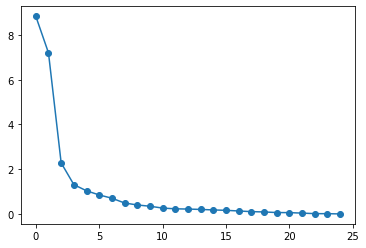

In [17]:
plt.plot(eigenvals, '-o')

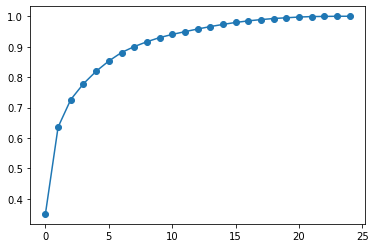

In [18]:
plt.plot(np.cumsum(eigenvals) / sum(eigenvals), '-o')



In [19]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scdf)
transformed = pca.transform(scdf)
print(transformed.shape)


features = range(pca.n_components_)
print(features)

(105, 25)
range(0, 25)


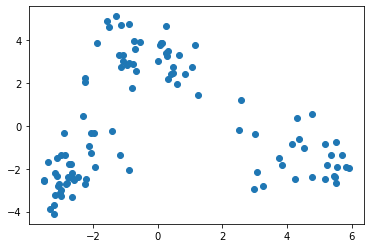

In [20]:
import matplotlib.pyplot as plt
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs, ys)
plt.show()


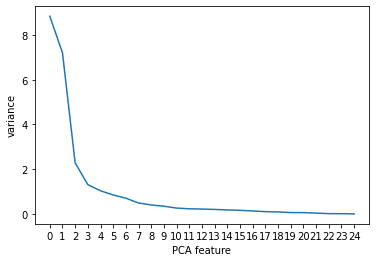

In [21]:
features = range(pca.n_components_)


plt.plot(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

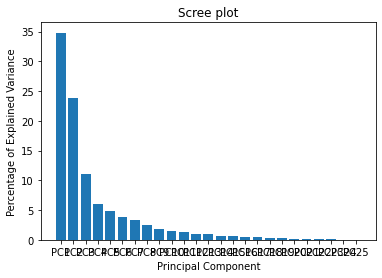

In [35]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree plot')
plt.show

In [44]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,4.377847,-0.604187,-0.644063,-0.632640,-0.144580,-0.067631,-0.232773,0.076987,0.352456,-0.936150,...,0.539841,-0.114302,0.084160,-0.371561,0.495148,-0.061825,-0.453016,-0.044975,0.049242,-0.034497
1,5.449361,-2.348626,0.586085,0.920875,1.262111,-0.749667,-0.282155,0.285576,0.547452,0.614353,...,-0.053183,-0.091705,-0.293890,-0.017103,0.127261,-0.168825,-0.017995,0.091134,0.004220,0.011609
2,2.566939,1.229861,3.197012,0.051097,-1.517839,0.199989,1.274236,-0.465495,0.011629,-0.405962,...,0.810726,-0.106548,0.520185,-0.305244,-0.133987,0.233700,-0.095423,-0.171831,0.076836,0.022605
3,4.155926,-0.823557,-2.215022,-0.886343,-0.030291,0.573919,-0.881615,0.840622,-0.075359,-0.414609,...,0.190545,-0.298068,0.574369,0.597375,0.016151,0.083248,-0.108341,-0.106900,-0.029763,0.022751
4,-1.503886,4.611612,-3.519502,0.699632,-1.287271,-1.337469,-1.748596,-1.202742,0.450574,0.335396,...,-0.000902,0.289635,-0.295479,0.311872,-0.142772,-0.526492,0.091053,0.429311,-0.038274,-0.103818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-1.196113,3.298491,-2.101391,0.600894,1.426998,-1.035472,-0.038955,0.058498,-0.857641,-0.127452,...,-0.174426,-0.109757,0.273446,-0.063675,-0.053324,-0.031590,0.032911,-0.200249,-0.114477,0.055404
101,-2.988314,-3.253176,-0.350712,1.168612,-0.094556,-0.218389,-0.503467,0.692371,-0.073064,0.186437,...,0.217624,-0.538372,-0.001230,-0.294099,-0.273308,-0.107828,0.268644,-0.003789,-0.171644,0.022743
102,-2.650506,-3.339529,-1.388056,-1.449190,-0.489651,-0.642277,1.133239,-0.676768,-0.770322,0.839909,...,0.393061,0.105432,0.012342,0.247537,-0.327765,-0.617317,-0.058620,-0.078545,0.062158,0.022902
103,-0.007131,3.056343,2.419142,1.159705,-1.503820,1.526336,-1.644425,0.042181,0.651861,-0.321374,...,-0.130424,0.022207,-0.295280,0.291470,0.044752,0.073935,-0.048496,0.007050,-0.080953,0.081426


In [55]:
pca_df = pd.DataFrame(transformed, index=labeled["genre1"], columns=labels)
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('my PCA Graph')
plt.xlabel('PC1-{0}%'.format(per_var[0]))
plt.ylabel('PC2-{0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
    
plt.show()

ValueError: Shape of passed values is (105, 25), indices imply (50, 25)

In [56]:
X = transformed
y = labeled['genre']

# Voorbeeld: aanpassen aan je eigen data en behoeften
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: Found input variables with inconsistent numbers of samples: [105, 50]

In [58]:
labeled

,genre,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,genre1
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,...,9.419415,6.914652,7.877784,-1.782740,1919.917650,1451.498371,24.225544,0.000351,3046.089914,0
m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,...,-4.261436,4.327076,-3.458247,1.208493,2019.252686,1811.358216,22.132186,0.016613,3854.901690,1
m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,...,0.891752,-0.496282,0.708363,1.672521,2992.192112,3111.061099,17.239507,-0.035761,6745.275879,2
m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,-69.599335,83.059570,-16.599525,0.119469,7.415704,0.769619,1.337008,...,4.043784,3.654379,1.913874,3.608692,2709.990169,2625.095044,19.452643,-0.018575,5606.407765,3
m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,-91.886307,87.604057,-2.058175,34.285538,-18.153368,19.344702,-14.697328,...,-11.649620,0.293441,-1.279737,0.098982,2486.020650,2550.135384,21.882917,0.009210,5585.291227,3
m00102.wav,classical,"[0.007843017578125, 0.00726318359375, 0.005828...",22050,-436.842346,154.113205,-19.859339,20.183603,3.164744,0.446392,-6.530638,...,-0.351299,2.226785,2.572540,4.476177,1517.856160,1173.931066,21.585652,0.043655,2083.120737,4
m00112.wav,reggae,"[-0.00262451171875, -0.003753662109375, -0.003...",22050,-265.694977,80.615921,9.722022,36.657085,27.836796,12.086828,15.014478,...,2.478586,1.273067,-0.217606,0.808830,2595.217468,2113.391954,17.757612,-0.040255,4785.929393,1
m00138.wav,reggae,"[-0.02630615234375, -0.028778076171875, -0.013...",22050,-198.632797,102.413582,-10.031449,30.802383,-3.310606,20.276924,-5.637373,...,-6.987337,1.113921,-1.494757,1.955205,2295.466240,1995.600514,21.412200,0.007691,4557.697440,1
m00192.wav,classical,"[0.069671630859375, 0.065948486328125, 0.04238...",22050,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922598,-10.950942,...,-3.392484,1.693799,-3.685389,-3.441533,1965.028715,1878.774030,18.892742,-0.010309,3634.069692,4


In [79]:
scala = scaler(labeled)
scala = scala.drop(['data', 'Hz'], axis=1)
display(scala)

,genre,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,NaN,-0.610133,-1.092007,1.885706,-1.009321,-0.201259,0.691769,0.192440,-0.480448,0.141330,...,-1.499082,-0.397462,0.463122,0.935166,-0.414782,-0.455867,0.173562,-0.548355,0.153848,-0.154394
m00039.wav,NaN,-0.411385,-0.573296,0.858330,-0.468786,0.548655,-0.021632,-0.323643,0.720894,-0.429996,...,-0.212583,0.563092,0.404405,0.230859,0.416474,0.080578,1.095719,-0.798675,0.182794,-0.490289
m00041.wav,NaN,1.535260,1.300127,-1.542893,1.462870,-1.866566,-0.978226,0.602749,-0.955740,1.142998,...,1.280696,0.712102,-1.004338,0.456144,-2.010779,0.114445,-1.459630,0.505158,-1.189411,0.923386
m00072.wav,NaN,0.970634,0.599644,-0.456732,0.701757,-1.074005,-0.618772,0.395646,-1.951990,-0.072418,...,0.776829,1.333851,-0.581885,-0.145913,-1.929537,0.626036,-1.291822,0.739165,-0.678809,0.677718
m00096.wav,NaN,0.522519,0.491595,0.735994,0.687644,0.207270,1.081365,-1.200355,0.852079,-0.673531,...,0.555532,0.206802,-0.418231,0.535055,-0.098669,-1.324775,0.422015,-0.831156,0.605457,-0.993899
m00102.wav,NaN,-1.414572,-1.492100,0.590103,-1.652879,1.795694,-1.794368,0.148566,-1.194111,0.006353,...,-2.869686,1.612420,1.976868,-0.298570,-0.854354,0.301705,-1.321645,-0.031352,-1.639415,-0.359739
m00112.wav,NaN,0.740998,-0.137938,-1.288618,0.153426,-2.073776,-0.252258,1.943612,-0.015465,1.430363,...,-1.170289,0.434751,-0.669884,1.086719,0.028416,2.184078,-0.247635,2.078666,0.398821,1.636401
m00138.wav,NaN,0.141260,-0.307725,0.504976,0.000897,0.137251,1.225330,-0.275168,0.912274,0.136321,...,-0.504400,0.802878,0.115084,0.161668,-0.285322,-0.192336,0.508027,0.056130,1.740265,-0.534648
m00192.wav,NaN,-0.519875,-0.476122,-0.731520,-0.616370,-0.692819,-1.405553,0.162346,-1.001521,0.153278,...,0.621278,-0.930139,0.691610,-0.842424,-0.849080,-0.276803,-0.724115,-0.464254,-1.331074,-0.036760


In [109]:
X = scala.drop(['genre'], axis=1)
y = labeled['genre']

# Voorbeeld: aanpassen aan je eigen data en behoeften
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Pas PCA toe
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [111]:
# Train een classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_pca, y_train)
y_pred = dt.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")


Nauwkeurigheid: 0.2


In [112]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=5, 
                             n_repeats=3, 
                             random_state=42)

param_dt= {
    'criterion': ['gini', 'entropy'],  
    'splitter': ['best', 'random'],    
    'max_depth': [None, 5, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['auto', 'sqrt', 'log2', None]  
}

gs = GridSearchCV(estimator=dt,
                    param_grid=param_dt,
                    cv=cv,
                    scoring='accuracy',
                    n_jobs=-1)
    
# Fitten van de grid search
gs.fit(X_train_pca, y_train)

# Tonen van de beste score en parameters
print(f"Beste accuracy: {gs.best_score_}")
print(f"Beste parameters:\n{gs.best_params_}")

Beste accuracy: 0.3333333333333333
Beste parameters:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2700 fits failed out of a total of 10800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1530 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Gebruiker\a

In [113]:
dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=5, max_features= 'log2', min_samples_leaf=1, min_samples_split=10, splitter='random', random_state=42)

dt_tuned.fit(X_train_pca, y_train)

y_pred = dt_tuned.predict(X_test)


# Bereken de nauwkeurigheid van het model
accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")

Nauwkeurigheid: 0.1


In [114]:
# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = dt_tuned.predict(X_unlabeled_pca)



# Laat de voorspelde genres zien
print(predicted_genres)

['rock' 'hiphop' 'hiphop' 'rock' 'classical' 'hiphop' 'hiphop' 'rock'
 'jazz' 'hiphop' 'hiphop' 'rock' 'jazz' 'jazz' 'pop' 'rock' 'rock'
 'classical' 'hiphop' 'hiphop' 'rock' 'hiphop' 'hiphop' 'hiphop' 'hiphop'
 'rock' 'jazz' 'hiphop' 'hiphop' 'hiphop' 'country' 'rock' 'classical'
 'jazz' 'rock' 'rock' 'hiphop' 'rock' 'rock' 'hiphop' 'rock' 'hiphop'
 'hiphop' 'pop' 'rock' 'pop' 'classical' 'jazz' 'classical' 'classical'
 'hiphop' 'hiphop' 'pop' 'pop' 'hiphop' 'classical' 'rock' 'rock'
 'classical' 'rock' 'classical' 'rock' 'hiphop' 'rock' 'classical' 'jazz'
 'rock' 'pop' 'jazz' 'jazz' 'pop' 'jazz' 'rock' 'hiphop' 'rock' 'pop'
 'jazz' 'jazz' 'classical' 'rock' 'hiphop' 'hiphop' 'rock' 'rock' 'pop'
 'hiphop' 'hiphop' 'classical' 'pop' 'hiphop' 'classical' 'rock' 'hiphop'
 'jazz' 'rock' 'pop' 'classical' 'pop' 'hiphop' 'jazz' 'hiphop' 'rock'
 'rock' 'country' 'jazz']


In [115]:
# Bepaal de unieke waarden en hun tellingen
unieke_waarden, tellingen = np.unique(predicted_genres, return_counts=True)

# Print de resultaten
for waarde, telling in zip(unieke_waarden, tellingen):
    print(f"{waarde}: {telling} keer")

classical: 14 keer
country: 2 keer
hiphop: 32 keer
jazz: 15 keer
pop: 12 keer
rock: 30 keer


In [87]:
(np.unique(predicted_genres))

array(['classical', 'country', 'hiphop', 'jazz', 'pop', 'rock'],
      dtype=object)

In [95]:
def pca_uitvoeren(X_train, X_test, y_train, classifier):
    
    # Pas PCA toe
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train een classifier
    model = classifier(random_state=42)
    model.fit(X_train_pca, y_train)


In [ ]:
   # Voorspel genres voor de ongelabelde data
    X_unlabeled_pca = pca.transform(scaled_df)
    predicted_genres = model.predict(X_unlabeled_pca)

    # Laat de voorspelde genres zien
    print(np.unique(predicted_genres))

In [96]:
from sklearn.linear_model import LogisticRegression

pca_uitvoeren(X_train, X_test, y_train, LogisticRegression)

In [116]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train_pca, y_train)

y_pred = logreg_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")

Nauwkeurigheid: 0.3


In [117]:
# Aanmaken parameter dictionary
param_lr = {
    'penalty': ['l2', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000, 5000]
}


gs = GridSearchCV(estimator=logreg_model,
                    param_grid=param_lr,
                    cv=cv,
                    scoring='accuracy',
                    n_jobs=-1)
    
# Fitten van de grid search
gs.fit(X_train_pca, y_train)

# Tonen van de beste score en parameters
print(f"Beste accuracy: {gs.best_score_}")
print(f"Beste parameters:\n{gs.best_params_}")


Beste accuracy: 0.36666666666666664
Beste parameters:
{'C': 1, 'max_iter': 500, 'penalty': 'l2'}


In [118]:
# Aanmaken verbeterd LR model
lr_tuned = LogisticRegression(solver='liblinear',
                              C=1,
                              max_iter=500,
                              penalty='l2',
                              random_state=42)


lr_tuned.fit(X_train_pca, y_train)

y_pred = lr_tuned.predict(X_test_pca)

# Bereken de nauwkeurigheid van het model
accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")

Nauwkeurigheid: 0.3


In [119]:
# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = dt_tuned.predict(X_unlabeled_pca)



# Laat de voorspelde genres zien
print(predicted_genres)
print(np.unique(predicted_genres))

['rock' 'hiphop' 'hiphop' 'rock' 'classical' 'hiphop' 'hiphop' 'rock'
 'jazz' 'hiphop' 'hiphop' 'rock' 'jazz' 'jazz' 'pop' 'rock' 'rock'
 'classical' 'hiphop' 'hiphop' 'rock' 'hiphop' 'hiphop' 'hiphop' 'hiphop'
 'rock' 'jazz' 'hiphop' 'hiphop' 'hiphop' 'country' 'rock' 'classical'
 'jazz' 'rock' 'rock' 'hiphop' 'rock' 'rock' 'hiphop' 'rock' 'hiphop'
 'hiphop' 'pop' 'rock' 'pop' 'classical' 'jazz' 'classical' 'classical'
 'hiphop' 'hiphop' 'pop' 'pop' 'hiphop' 'classical' 'rock' 'rock'
 'classical' 'rock' 'classical' 'rock' 'hiphop' 'rock' 'classical' 'jazz'
 'rock' 'pop' 'jazz' 'jazz' 'pop' 'jazz' 'rock' 'hiphop' 'rock' 'pop'
 'jazz' 'jazz' 'classical' 'rock' 'hiphop' 'hiphop' 'rock' 'rock' 'pop'
 'hiphop' 'hiphop' 'classical' 'pop' 'hiphop' 'classical' 'rock' 'hiphop'
 'jazz' 'rock' 'pop' 'classical' 'pop' 'hiphop' 'jazz' 'hiphop' 'rock'
 'rock' 'country' 'jazz']
['classical' 'country' 'hiphop' 'jazz' 'pop' 'rock']


In [120]:
# Bepaal de unieke waarden en hun tellingen
unieke_waarden, tellingen = np.unique(predicted_genres, return_counts=True)

# Print de resultaten
for waarde, telling in zip(unieke_waarden, tellingen):
    print(f"{waarde}: {telling} keer")

classical: 14 keer
country: 2 keer
hiphop: 32 keer
jazz: 15 keer
pop: 12 keer
rock: 30 keer


In [121]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

knn_classifier.fit(X_train_pca, y_train)

y_pred = knn_classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")


Nauwkeurigheid: 0.2


In [122]:
params_knn = {'weights':['uniform', 'distance'],
             'metric':['minkowski','euclidean','manhattan' ],
             'algorithm':['ball_tree', 'kd_tree', 'brute']}

gs = GridSearchCV(estimator=knn_classifier,
                    param_grid=params_knn,
                    cv=cv,
                    scoring='accuracy',
                    n_jobs=-1)
    
    # Fitten van de grid search
gs.fit(X_train_pca, y_train)

    # Tonen van de beste score en parameters
print(f"Beste accuracy: {gs.best_score_}")
print(f"Beste parameters:\n{gs.best_params_}")

Beste accuracy: 0.4
Beste parameters:
{'algorithm': 'ball_tree', 'metric': 'manhattan', 'weights': 'distance'}


In [123]:
knn_tuned = KNeighborsClassifier(algorithm='ball_tree',
                                n_jobs=-1,
                                metric='manhattan',
                                n_neighbors=3,
                                weights='distance')

knn_tuned.fit(X_train_pca, y_train)

y_pred = knn_tuned.predict(X_test_pca)

# Bereken de nauwkeurigheid van het model
accuracy = accuracy_score(y_test, y_pred)
print(f"Nauwkeurigheid: {accuracy}")


Nauwkeurigheid: 0.3


In [124]:
# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = dt_tuned.predict(X_unlabeled_pca)



# Laat de voorspelde genres zien
print(predicted_genres)
print(np.unique(predicted_genres))

['rock' 'hiphop' 'hiphop' 'rock' 'classical' 'hiphop' 'hiphop' 'rock'
 'jazz' 'hiphop' 'hiphop' 'rock' 'jazz' 'jazz' 'pop' 'rock' 'rock'
 'classical' 'hiphop' 'hiphop' 'rock' 'hiphop' 'hiphop' 'hiphop' 'hiphop'
 'rock' 'jazz' 'hiphop' 'hiphop' 'hiphop' 'country' 'rock' 'classical'
 'jazz' 'rock' 'rock' 'hiphop' 'rock' 'rock' 'hiphop' 'rock' 'hiphop'
 'hiphop' 'pop' 'rock' 'pop' 'classical' 'jazz' 'classical' 'classical'
 'hiphop' 'hiphop' 'pop' 'pop' 'hiphop' 'classical' 'rock' 'rock'
 'classical' 'rock' 'classical' 'rock' 'hiphop' 'rock' 'classical' 'jazz'
 'rock' 'pop' 'jazz' 'jazz' 'pop' 'jazz' 'rock' 'hiphop' 'rock' 'pop'
 'jazz' 'jazz' 'classical' 'rock' 'hiphop' 'hiphop' 'rock' 'rock' 'pop'
 'hiphop' 'hiphop' 'classical' 'pop' 'hiphop' 'classical' 'rock' 'hiphop'
 'jazz' 'rock' 'pop' 'classical' 'pop' 'hiphop' 'jazz' 'hiphop' 'rock'
 'rock' 'country' 'jazz']
['classical' 'country' 'hiphop' 'jazz' 'pop' 'rock']


In [125]:
# Bepaal de unieke waarden en hun tellingen
unieke_waarden, tellingen = np.unique(predicted_genres, return_counts=True)

# Print de resultaten
for waarde, telling in zip(unieke_waarden, tellingen):
    print(f"{waarde}: {telling} keer")

classical: 14 keer
country: 2 keer
hiphop: 32 keer
jazz: 15 keer
pop: 12 keer
rock: 30 keer


In [128]:
scdf['predicted_genres'] = predicted_genres
scdf

,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,...,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,predicted_genres
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-0.282118,-0.118884,0.078336,-0.205532,-0.332126,0.799924,-0.702495,1.488357,-1.685314,1.456281,...,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265,rock
m00012.wav,0.019216,0.616770,-0.083214,0.293430,-0.452162,1.774594,-1.563891,2.138239,-1.147957,1.455962,...,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620,hiphop
m00013.wav,-0.569065,-0.458058,1.447517,-0.498065,-0.085519,1.003829,-0.550030,-0.412775,-1.571745,1.161850,...,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202,hiphop
m00043.wav,-0.278768,0.027796,-0.236340,-0.106240,0.005644,0.965347,-0.670623,1.455360,-0.839766,0.583486,...,-1.208862,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518,rock
m00044.wav,-1.920661,-1.766122,0.018429,-1.774679,-1.382611,-1.840896,-0.487663,-1.535571,-0.520888,-1.476432,...,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570093,-0.993139,-1.095278,-0.188952,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.957653,-0.938974,-0.551006,-1.008327,0.725921,-1.676399,0.555313,-1.169117,0.266517,-1.033799,...,0.042968,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994,hiphop
m00973.wav,1.431593,1.475285,-1.196850,1.498087,-1.137006,-0.110127,0.497143,-0.286592,0.372095,-0.688076,...,0.745321,-1.137606,1.381635,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714,rock
m00988.wav,1.523881,1.778059,-1.318630,1.683362,-0.606247,0.000735,1.486701,0.254812,0.771619,0.368334,...,-1.140236,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906,rock


In [53]:
labeled["genre1"] = pd.factorize(labeled["genre"])[0]
labeled['genre1']

filename
m00002.wav    0
m00039.wav    1
m00041.wav    2
m00072.wav    3
m00096.wav    3
m00102.wav    4
m00112.wav    1
m00138.wav    1
m00192.wav    4
m00206.wav    5
m00230.wav    6
m00236.wav    4
m00248.wav    7
m00253.wav    8
m00298.wav    8
m00313.wav    8
m00338.wav    8
m00339.wav    9
m00351.wav    0
m00400.wav    8
m00421.wav    2
m00429.wav    5
m00435.wav    4
m00454.wav    5
m00477.wav    4
m00501.wav    0
m00503.wav    7
m00513.wav    2
m00553.wav    3
m00606.wav    6
m00623.wav    1
m00627.wav    7
m00629.wav    6
m00633.wav    6
m00637.wav    5
m00658.wav    5
m00671.wav    1
m00676.wav    2
m00677.wav    6
m00678.wav    7
m00716.wav    0
m00762.wav    3
m00772.wav    9
m00773.wav    2
m00801.wav    9
m00821.wav    7
m00850.wav    3
m00867.wav    9
m00895.wav    9
m00996.wav    0
Name: genre1, dtype: int64

ValueError: 'c' argument has 50 elements, which is inconsistent with 'x' and 'y' with size 105.

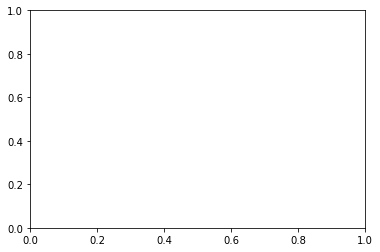

In [43]:
plt.scatter(xs, ys, c=labeled["genre"])

In [46]:
scala = scaler(labeled)
scala = scala.drop(['data', 'Hz'], axis=1)
display(scala)

,genre,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-1.566699,-0.610133,-1.092007,1.885706,-1.009321,-0.201259,0.691769,0.192440,-0.480448,0.141330,...,-1.499082,-0.397462,0.463122,0.935166,-0.414782,-0.455867,0.173562,-0.548355,0.153848,-0.154394
m00039.wav,-1.218544,-0.411385,-0.573296,0.858330,-0.468786,0.548655,-0.021632,-0.323643,0.720894,-0.429996,...,-0.212583,0.563092,0.404405,0.230859,0.416474,0.080578,1.095719,-0.798675,0.182794,-0.490289
m00041.wav,-0.870388,1.535260,1.300127,-1.542893,1.462870,-1.866566,-0.978226,0.602749,-0.955740,1.142998,...,1.280696,0.712102,-1.004338,0.456144,-2.010779,0.114445,-1.459630,0.505158,-1.189411,0.923386
m00072.wav,-0.522233,0.970634,0.599644,-0.456732,0.701757,-1.074005,-0.618772,0.395646,-1.951990,-0.072418,...,0.776829,1.333851,-0.581885,-0.145913,-1.929537,0.626036,-1.291822,0.739165,-0.678809,0.677718
m00096.wav,-0.522233,0.522519,0.491595,0.735994,0.687644,0.207270,1.081365,-1.200355,0.852079,-0.673531,...,0.555532,0.206802,-0.418231,0.535055,-0.098669,-1.324775,0.422015,-0.831156,0.605457,-0.993899
m00102.wav,-0.174078,-1.414572,-1.492100,0.590103,-1.652879,1.795694,-1.794368,0.148566,-1.194111,0.006353,...,-2.869686,1.612420,1.976868,-0.298570,-0.854354,0.301705,-1.321645,-0.031352,-1.639415,-0.359739
m00112.wav,-1.218544,0.740998,-0.137938,-1.288618,0.153426,-2.073776,-0.252258,1.943612,-0.015465,1.430363,...,-1.170289,0.434751,-0.669884,1.086719,0.028416,2.184078,-0.247635,2.078666,0.398821,1.636401
m00138.wav,-1.218544,0.141260,-0.307725,0.504976,0.000897,0.137251,1.225330,-0.275168,0.912274,0.136321,...,-0.504400,0.802878,0.115084,0.161668,-0.285322,-0.192336,0.508027,0.056130,1.740265,-0.534648
m00192.wav,-0.174078,-0.519875,-0.476122,-0.731520,-0.616370,-0.692819,-1.405553,0.162346,-1.001521,0.153278,...,0.621278,-0.930139,0.691610,-0.842424,-0.849080,-0.276803,-0.724115,-0.464254,-1.331074,-0.036760


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

X = scala.drop(['genre'], axis=1)
y = labeled['genre']

# Voorbeeld: aanpassen aan je eigen data en behoeften
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pas PCA toe
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train een classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_pca, y_train)

# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = classifier.predict(X_unlabeled_pca)

# Laat de voorspelde genres zien
print(predicted_genres)


[2 7 1 5 4 3 7 5 4 4 3 3 1 2 2 2 5 4 0 5 2 2 9 3 0 5 0 5 4 5 3 2 0 0 1 2 5
 3 3 5 2 5 5 3 2 2 4 0 4 4 3 0 2 3 6 4 0 3 4 3 4 2 9 3 4 0 9 2 0 1 2 0 2 1
 5 3 4 2 4 2 5 9 9 2 2 9 3 4 2 2 4 6 7 6 0 2 4 2 5 0 4 2 2 3 0]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

X = sc_la.drop(['genre'], axis=1)
y = labeled['genre']

# Voorbeeld: aanpassen aan je eigen data en behoeften
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pas PCA toe
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train een classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_pca, y_train)

# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = classifier.predict(X_unlabeled_pca)

# Laat de voorspelde genres zien
print(predicted_genres)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

X = sc_la.drop(['genre'], axis=1)
y = labeled['genre']

# Voorbeeld: aanpassen aan je eigen data en behoeften
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pas PCA toe
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train de DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_pca, y_train)

# Voorspel genres voor de ongelabelde data
X_unlabeled_pca = pca.transform(scdf)
predicted_genres = classifier.predict(X_unlabeled_pca)

# Laat de voorspelde genres zien
print(predicted_genres)

['hiphop' 'metal' 'reggae' 'disco' 'classical' 'reggae' 'disco' 'hiphop'
 'classical' 'classical' 'disco' 'reggae' 'reggae' 'pop' 'country' 'pop'
 'metal' 'classical' 'jazz' 'metal' 'pop' 'pop' 'classical' 'metal'
 'reggae' 'hiphop' 'jazz' 'disco' 'reggae' 'hiphop' 'disco' 'reggae'
 'classical' 'jazz' 'metal' 'pop' 'metal' 'pop' 'metal' 'jazz' 'pop'
 'hiphop' 'hiphop' 'disco' 'reggae' 'pop' 'jazz' 'jazz' 'classical'
 'classical' 'hiphop' 'jazz' 'pop' 'reggae' 'reggae' 'classical' 'jazz'
 'disco' 'reggae' 'reggae' 'classical' 'pop' 'hiphop' 'reggae' 'classical'
 'reggae' 'disco' 'disco' 'jazz' 'jazz' 'pop' 'jazz' 'pop' 'hiphop'
 'hiphop' 'disco' 'classical' 'hiphop' 'classical' 'pop' 'hiphop' 'jazz'
 'rock' 'pop' 'country' 'jazz' 'pop' 'classical' 'disco' 'hiphop'
 'country' 'country' 'metal' 'rock' 'jazz' 'pop' 'country' 'pop' 'metal'
 'jazz' 'jazz' 'pop' 'pop' 'blues' 'jazz']


In [34]:
(np.unique(predicted_genres))

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [31]:
(np.unique(predicted_genres))

array(['classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop',
       'reggae', 'rock'], dtype=object)

In [32]:
(np.unique(labeled['genre']))

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [29]:
unlabeled['Predicted_Genre'] = predicted_genres

In [30]:
unlabeled

,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mfcc17_mean,mfcc18_mean,mfcc19_mean,mfcc20_mean,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,Predicted_Genre
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,"[-0.129364013671875, -0.1422119140625, -0.1157...",22050,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,...,-7.204545,0.667606,-4.838900,-2.107008,2070.908729,2254.451748,20.382411,0.005218,4381.173508,pop
m00012.wav,"[-0.003814697265625, 0.089080810546875, 0.1600...",22050,-1.925411,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,...,-9.025781,4.315321,-5.643383,8.725261,2286.246872,2908.260266,20.043229,0.001804,5405.642313,metal
m00013.wav,"[0.004791259765625, 0.0048828125, 0.0045166015...",22050,-287.520996,101.737930,-35.368999,41.282764,-12.745123,17.284992,-13.978298,16.311884,...,7.031875,8.390631,-5.610771,1.377122,1865.851544,1953.012399,23.257077,0.012233,3780.543806,hiphop
m00043.wav,"[-0.11505126953125, -0.12127685546875, -0.1372...",22050,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123723,23.654572,...,-10.713960,-3.241502,-3.466504,-4.576841,2073.302486,2384.812610,19.721734,0.014826,4585.038942,hiphop
m00044.wav,"[-0.017822265625, -0.016693115234375, -0.01486...",22050,-437.525208,170.971405,7.386171,-3.108705,0.777302,-11.135056,-12.523807,-6.900928,...,-6.652506,-4.291024,-4.399244,-4.915998,899.979779,790.478225,20.256635,-0.024661,1159.401323,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,"[-0.001007080078125, 0.002288818359375, 0.0039...",22050,-246.218369,149.443878,-41.973816,11.606412,-10.287586,-4.018404,-7.138945,-10.137027,...,-3.349317,-3.344110,-0.673095,0.217880,1588.161024,1525.601267,19.061078,0.035313,2732.875141,classical
m00973.wav,"[0.106842041015625, 0.13616943359375, 0.074645...",22050,-8.531343,54.251755,20.963310,13.099079,9.721153,6.015052,10.720785,6.102119,...,1.705013,-0.146839,4.848467,2.908009,3295.553789,3671.260489,17.705096,-0.017675,7879.044023,pop
m00988.wav,"[0.00384521484375, 0.023468017578125, 0.071441...",22050,-56.091187,36.468166,11.945320,-6.441752,3.778163,5.284157,3.394784,4.265098,...,-1.428112,-1.871160,-5.389884,-4.313989,3361.504206,3940.349921,17.449413,-0.002578,8259.450056,pop


In [52]:
labeled.keys()

Index(['genre', 'data', 'Hz', 'mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean',
       'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean',
       'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean',
       'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean',
       'mfcc17_mean', 'mfcc18_mean', 'mfcc19_mean', 'mfcc20_mean',
       'mean_bandwidth', 'mean_centroids', 'mean_spectral_contrast',
       'mean_tonnetz', 'mean_spectral_rolloff'],
      dtype='object')

In [136]:
scdf = scdf.drop('predicted_genres', axis=1)

In [137]:
scdf


,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_spectral_rolloff,mean_tonnetz,mfcc10_mean,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-0.282118,-0.118884,0.078336,-0.205532,-0.332126,0.799924,-0.702495,1.488357,-1.685314,1.456281,...,0.484487,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265
m00012.wav,0.019216,0.616770,-0.083214,0.293430,-0.452162,1.774594,-1.563891,2.138239,-1.147957,1.455962,...,1.074915,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620
m00013.wav,-0.569065,-0.458058,1.447517,-0.498065,-0.085519,1.003829,-0.550030,-0.412775,-1.571745,1.161850,...,-1.017818,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202
m00043.wav,-0.278768,0.027796,-0.236340,-0.106240,0.005644,0.965347,-0.670623,1.455360,-0.839766,0.583486,...,0.208774,-1.208862,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518
m00044.wav,-1.920661,-1.766122,0.018429,-1.774679,-1.382611,-1.840896,-0.487663,-1.535571,-0.520888,-1.476432,...,-2.116991,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570093,-0.993139,-1.095278,-0.188952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m00971.wav,-0.957653,-0.938974,-0.551006,-1.008327,0.725921,-1.676399,0.555313,-1.169117,0.266517,-1.033799,...,-0.715169,0.042968,1.277592,-1.274369,-0.838470,-0.847983,-0.982974,-0.438186,-1.385951,-0.626994
m00973.wav,1.431593,1.475285,-1.196850,1.498087,-1.137006,-0.110127,0.497143,-0.286592,0.372095,-0.688076,...,1.026509,0.745321,-1.137606,1.381635,-0.765037,0.936434,-0.155219,1.402402,0.072683,0.612714
m00988.wav,1.523881,1.778059,-1.318630,1.683362,-0.606247,0.000735,1.486701,0.254812,0.771619,0.368334,...,0.678009,-1.140236,-1.588808,1.001067,-1.726364,0.406427,-0.215518,0.647399,-0.092322,1.506906


In [139]:
pca3 = PCA(n_components=3)
pca3.fit(scdf)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(scdf)

regression_model_pca = LogisticRegressionticRegression()
regression_model_pca.fit(Xpca3, y)
regression_model_pca.score(Xpca3, y)

[[-0.11835291 -0.05124445  0.13182293 -0.07825546 -0.01908605  0.23795143
  -0.23428391  0.25656902 -0.2556369   0.22644909 -0.22696236  0.18103007
  -0.2050032   0.09392105 -0.22527458  0.0423462   0.00440048  0.03293078
  -0.24099157  0.29388514 -0.26137985  0.25238353 -0.2501858   0.26243134
  -0.26235828]
 [-0.34169423 -0.35655824  0.28230535 -0.35441904  0.17511959 -0.2017982
  -0.07000378 -0.15033709  0.03784819 -0.13340937  0.06751231 -0.03457713
   0.10069892 -0.0501161   0.01306793 -0.32354039 -0.11403358  0.35642364
  -0.17027927 -0.05962132 -0.09838229 -0.1767492  -0.19104048 -0.19088033
  -0.15160327]
 [-0.0421935  -0.02550148  0.13981093 -0.03612826 -0.00392755  0.15144879
   0.06767947  0.04799539  0.15078948  0.19325259  0.30136466  0.44733807
   0.37530759  0.48187358  0.26234799 -0.11465559  0.34279592 -0.01329602
  -0.07897424  0.02235438  0.01870243  0.05465416  0.01792022  0.05015716
   0.10118429]]
[0.35025299 0.28547544 0.09047855]


ValueError: Found input variables with inconsistent numbers of samples: [105, 50]